In [5]:

import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle


In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

'''
You instantiate it with the same arguments used for the normalize. and then use it the same way

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(tensor)

'''

'\nYou instantiate it with the same arguments used for the normalize. and then use it the same way\n\nunorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))\nunorm(tensor)\n\n'

In [ ]:
class resnet50(nn.Module):
    def __init__(self,num_classes=22):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50(pretrained=True)
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

        
network = resnet50()
network.load_state_dict(torch.load('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/regressors/models/model_resnet50_regressor_finetune.pth'))
network.cuda()
network.eval()

In [8]:
# makke landmark predictions on Vol 20-21 adding to biological data csv. 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

csv_dir = 'C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/Pipeline/Results/Results_2021_03_28/results_final.csv'
#csv_dir = "D:/Tsetse fly Project/Data/Vols2021DataforMorphometricsOct2020.csv"
V20 = "G:/tsetse wings/V20rename/V20/"
V21 = "G:/tsetse wings/V21rename/"
#csv = pd.read_csv(csv_dir, sep=';')
csv = pd.read_csv(csv_dir, index_col=0)
print(csv)

pred_l = np.zeros((len(csv), 22))
pred_r = np.zeros((len(csv), 22))
counter = 0
start_time = time.time()
for row in range(len(csv)):
    counter += 1
    if counter == 7000:
        print('half way')
    #   V20
    if int(str(csv.iloc[row,0])[:2]) == 20: 
        if (('V20P{}L{}L.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]) in os.listdir(V20 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ))) and ('V20P{}L{}R.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]) in os.listdir(V20 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') )))):
        #filename_ = 'V20P{}L{}L.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:])
        #if filename_ in os.listdir(V20 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') )):

            im_L = Image.open(V20 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ) + 'V20P{}L{}L.bmp'.format                   (str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]))

            with torch.no_grad():
                im_L = TF.resize(im_L, (224,224))
                im_L = TF.to_tensor(im_L).cuda()
                im_L = TF.normalize(im_L, [0.5], [0.5])
                im_L = torch.reshape(im_L, (1, 3, 224, 224))
                predictionL = (network(im_L) + 0.5)
                predictionL = predictionL.view(-1,11,2)*torch.tensor([1280, 1024]).cuda()
                predictionL = predictionL.flatten()
                pred_l[row, :] = predictionL.cpu().numpy()

              

            im_R = Image.open(V20 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ) + 'V20P{}L{}R.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]))
            im_R = im_R.transpose(method=Image.FLIP_LEFT_RIGHT) 


            with torch.no_grad():
                im_R = TF.resize(im_R, (224,224))
                im_R = TF.to_tensor(im_R).cuda()
                im_R = TF.normalize(im_R, [0.5], [0.5])
                im_R = torch.reshape(im_R, (1, 3, 224, 224))
                predictionR = (network(im_R) + 0.5)
                predictionR = predictionR.view(-1,11,2)*torch.tensor([1280, 1024]).cuda()
                predictionR = predictionR.flatten()
                pred_r[row, :] = predictionR.cpu().numpy()
               
        else:
            pred_l[row, :] = np.zeros((1,22))
            pred_r[row, :] = np.zeros((1,22))

    elif int(str(csv.iloc[row,0])[:2]) == 21:
        if ('V21P{}L{}L.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]) in os.listdir(V21 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ))) and ('V21P{}L{}R.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]) in os.listdir(V21 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ))):

            im_L = Image.open(V21 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ) + 'V21P{}L{}L.bmp'.format(str                   (csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]))

            with torch.no_grad():
                im_L = TF.resize(im_L, (224,224))
                im_L = TF.to_tensor(im_L).cuda()
                im_L = TF.normalize(im_L, [0.5], [0.5])
                im_L = torch.reshape(im_L, (1, 3, 224, 224))
                predictionL = (network(im_L) + 0.5)
                predictionL = predictionL.view(-1,11,2)*torch.tensor([1280, 1024]).cuda()
                predictionL = predictionL.flatten()
                pred_l[row, :] = predictionL.cpu().numpy()
                

            im_R = Image.open(V21 + 'page{}/Picture/'.format( str(csv.iloc[row,0])[-5:-2].lstrip('0') ) + 'V21P{}L{}R.bmp'.format(str(csv.iloc[row,0])[-5:-2],str(csv.iloc[row,0])[-2:]))
            im_R = im_R.transpose(method=Image.FLIP_LEFT_RIGHT) 


            with torch.no_grad():
                im_R = TF.resize(im_R, (224,224))
                im_R = TF.to_tensor(im_R).cuda()
                im_R = TF.normalize(im_R, [0.5], [0.5])
                im_R = torch.reshape(im_R, (1, 3, 224, 224))
                predictionR = (network(im_R) + 0.5)
                predictionR = predictionR.view(-1,11,2)*torch.tensor([1280, 1024]).cuda()
                predictionR = predictionR.flatten()
                pred_r[row, :] = predictionR.cpu().numpy()
        else:
            pred_l[row, :] = np.zeros((1,22))
            pred_r[row, :] = np.zeros((1,22))

pred_l = pd.DataFrame(pred_l, columns = ['l_x1','l_y1','l_x2','l_y2','l_x3','l_y3','l_x4','l_y4','l_x5','l_y5','l_x6','l_y6','l_x7','l_y7','l_x8','l_y8','l_x9','l_y9','l_x10','l_y10','l_x11','l_y11' ])
pred_r = pd.DataFrame(pred_r, columns = ['r_x1','r_y1','r_x2','r_y2','r_x3','r_y3','r_x4','r_y4','r_x5','r_y5','r_x6','r_y6','r_x7','r_y7','r_x8','r_y8','r_x9','r_y9','r_x10','r_y10','r_x11','r_y11' ] )
csv = pd.concat([csv, pred_l], axis = 1)
csv = pd.concat([csv, pred_r], axis = 1)


print("Total Elapsed Time : {} s".format(time.time()-start_time))
csv.to_csv('regression_results.csv')

            vpn  cd        cm  cy                 md   g  s    c  wlm  f  \
0      20000101   4  November  94  Odour-baited trap  Gp  2  1.0  732  3   
1      20000102   4  November  94  Odour-baited trap  Gp  2  5.0  732  4   
2      20000103   4  November  94  Odour-baited trap  Gp  2  5.0  723  5   
3      20000104   4  November  94  Odour-baited trap  Gp  2  4.0  732  5   
4      20000105   4  November  94  Odour-baited trap  Gp  2  7.0  713  3   
...         ...  ..       ...  ..                ...  .. ..  ...  ... ..   
14603  21077806  21      July  96  Odour-baited trap  Gp  2  0.0  771  1   
14604  21077807  21      July  96  Odour-baited trap  Gp  2  2.0  752  3   
14605  21077808  21      July  96  Odour-baited trap  Gp  2  2.0  752  2   
14606  21077809  21      July  96  Odour-baited trap  Gp  2  1.0  761  2   
14607  21077810  22      July  96  Odour-baited trap  Gp  2  1.0  771  1   

       lmkl  lmkr  hc left_good right_good  
0         0     0   0         0          0

In [6]:
csv

,vpn,cd,cm,cy,md,g,s,c,wlm,f,...,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x11,r_y11,dis_l,dis_r
0,20000101,4,November,94,Odour-baited trap,Gp,2,1.0,732,3,...,567.407898,690.841309,1008.238159,405.378510,624.709961,468.400269,893.093994,364.388000,439.839662,436.478754
1,20000102,4,November,94,Odour-baited trap,Gp,2,5.0,732,4,...,542.927429,728.493164,947.673096,387.652985,552.256104,514.420044,824.600769,366.947876,434.916648,428.534562
2,20000103,4,November,94,Odour-baited trap,Gp,2,5.0,723,5,...,650.182434,724.347778,1017.349243,368.749390,656.613281,505.309296,898.226379,349.583191,415.208752,421.945387
3,20000104,4,November,94,Odour-baited trap,Gp,2,4.0,732,5,...,570.792053,730.368652,940.993774,353.971252,582.796387,498.054413,822.565796,341.588074,437.821254,431.100084
4,20000105,4,November,94,Odour-baited trap,Gp,2,7.0,713,3,...,586.255554,719.888794,927.340332,345.240295,574.275330,508.584442,811.252502,337.807953,419.640480,422.824412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14663,21077806,21,July,96,Odour-baited trap,Gp,2,0.0,771,1,...,605.018188,769.036926,1063.527832,438.907074,645.663330,531.761475,934.227295,407.265564,451.128382,450.101400
14664,21077807,21,July,96,Odour-baited trap,Gp,2,2.0,752,3,...,558.620972,745.570129,1010.128479,422.642853,601.183533,511.324036,882.647705,390.960999,453.030198,442.345351
14665,21077808,21,July,96,Odour-baited trap,Gp,2,2.0,752,2,...,625.724670,720.502808,1057.525879,427.054657,671.801880,503.216705,934.443054,393.638123,436.036402,422.678203
14666,21077809,21,July,96,Odour-baited trap,Gp,2,1.0,761,2,...,556.815125,742.536499,1031.479492,462.903015,609.209961,517.442627,906.323486,416.454071,445.500707,440.840829


In [11]:
import pandas as pd
csv = pd.read_csv('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/Pipeline/Results/Results_2021_03_28/landmarks_coordinates.csv', index_col= 0, sep = ';')

In [12]:
 #17,18    ---   27, 28  <-- landmark 0 
# 39, 40             ----   49, 50

# calculate distances and append to csv
import math
import numpy as np
dis_l = np.zeros((len(csv), 1))
dis_r = np.zeros((len(csv), 1))

for row in range(len(csv)):
    lp1 = [csv.loc[row, 'l_x1'], csv.loc[row,'l_y1']]
    lp6 = [csv.loc[row, 'l_x6'], csv.loc[row, 'l_y6']]
    rp1 = [csv.loc[row, 'r_x1'], csv.loc[row, 'r_y1']]
    rp6 = [csv.loc[row, 'r_x6'], csv.loc[row, 'r_y6']]
    distancel = math.sqrt( ((lp1[0]-lp6[0])**2)+((lp1[1]-lp6[1])**2) )
    distancer = math.sqrt( ((rp1[0]-rp6[0])**2)+((rp1[1]-rp6[1])**2) )
    dis_l[row, :] = distancel
    dis_r[row, :] = distancer
dis_l = pd.DataFrame(dis_l, columns = ['dis_l'])
dis_r = pd.DataFrame(dis_r, columns = ['dis_r'])
csv = pd.concat([csv, dis_l], axis = 1)
csv = pd.concat([csv, dis_r], axis = 1)
csv.to_csv('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/Pipeline/Results/Results_2021_03_28/final_unclean.csv')

In [19]:
csv


,vpn,cd,cm,cy,md,g,s,c,wlm,f,...,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x11,r_y11,dis_l,dis_r
0,20000101,4,November,94,Odour-baited trap,Gp,2,1.0,732,3,...,567.407898,690.841309,1008.238159,405.378510,624.709961,468.400269,893.093994,364.388000,1037.957322,1039.492698
1,20000102,4,November,94,Odour-baited trap,Gp,2,5.0,732,4,...,542.927429,728.493164,947.673096,387.652985,552.256104,514.420044,824.600769,366.947876,1050.851960,1052.572986
2,20000103,4,November,94,Odour-baited trap,Gp,2,5.0,723,5,...,650.182434,724.347778,1017.349243,368.749390,656.613281,505.309296,898.226379,349.583191,1019.754228,1015.082370
3,20000104,4,November,94,Odour-baited trap,Gp,2,4.0,732,5,...,570.792053,730.368652,940.993774,353.971252,582.796387,498.054413,822.565796,341.588074,1047.866079,1028.499505
4,20000105,4,November,94,Odour-baited trap,Gp,2,7.0,713,3,...,586.255554,719.888794,927.340332,345.240295,574.275330,508.584442,811.252502,337.807953,1024.401362,1013.314764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14663,21077806,21,July,96,Odour-baited trap,Gp,2,0.0,771,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14664,21077807,21,July,96,Odour-baited trap,Gp,2,2.0,752,3,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14665,21077808,21,July,96,Odour-baited trap,Gp,2,2.0,752,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14666,21077809,21,July,96,Odour-baited trap,Gp,2,1.0,761,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


14668
            vpn  cd        cm  cy                 md   g  s    c  wlm  f  ...  \
0      20000101   4  November  94  Odour-baited trap  Gp  2  1.0  732  3  ...   
1      20000102   4  November  94  Odour-baited trap  Gp  2  5.0  732  4  ...   
2      20000103   4  November  94  Odour-baited trap  Gp  2  5.0  723  5  ...   
3      20000104   4  November  94  Odour-baited trap  Gp  2  4.0  732  5  ...   
4      20000105   4  November  94  Odour-baited trap  Gp  2  7.0  713  3  ...   
...         ...  ..       ...  ..                ...  .. ..  ...  ... ..  ...   
14663  21077806  21      July  96  Odour-baited trap  Gp  2  0.0  771  1  ...   
14664  21077807  21      July  96  Odour-baited trap  Gp  2  2.0  752  3  ...   
14665  21077808  21      July  96  Odour-baited trap  Gp  2  2.0  752  2  ...   
14666  21077809  21      July  96  Odour-baited trap  Gp  2  1.0  761  2  ...   
14667  21077810  22      July  96  Odour-baited trap  Gp  2  1.0  771  1  ...   

             r_x8    

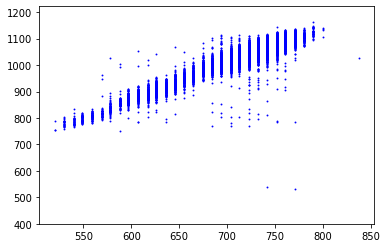

In [11]:

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
csv_dir = 'C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/Pipeline/regression/lm_preds_cleaned_data1.csv'
#csv_dir = "D:/Tsetse fly Project/Data/Vols2021DataforMorphometricsOct2020.csv"
V20 = "F:/tsetse wings/V20rename/V20/"
V21 = "F:/tsetse wings/V21rename/"


#csv = pd.read_csv(csv_dir, sep=';')
csv = pd.read_csv(csv_dir, sep = ',', index_col=0)
print(len(csv))
print(csv)
lm_csv = csv[csv.iloc[:,13]== '0']
print(len(lm_csv))
lm_csv = lm_csv[csv.iloc[:,14]== '0']


#
#plt.scatter(lm_csv.iloc[:,8], lm_csv.iloc[:,-1], s=0.8)
#plt.ylim(400,)
#plt.xlabel('wlm')
#plt.ylabel('L 0-5')
#plt.title('unclean')
#plt.show()
for i in range(len(lm_csv)):
    if str(lm_csv.iloc[i,0])[-5:-2].lstrip('0') not in [36, 48, 208, 209, 210, 211,212,213,214,215,216,217,218,219,220,221,223,224,225,228,321,336,398,328]:
        plt.scatter(lm_csv.iloc[i,8], lm_csv.iloc[i,-1], color = 'b', s=0.8)
plt.ylim(400,)
plt.show()


In [ ]:
# linear regression 

#csv = pd.read_csv(csv_dir, sep=';')
csv = pd.read_csv(csv_dir, sep = ',', index_col=0)
print(len(csv))
print(csv)
lm_csv = csv[csv.iloc[:,13]== '0']
print(len(lm_csv))
lm_csv = lm_csv[csv.iloc[:,14]== '0']
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
print('1')
linreg.fit(np.array(lm_csv.iloc[:,8]).reshape((-1,1)), lm_csv.iloc[:,-1])
print('2')
y_predicted = linreg.predict(lm_csv.iloc[:,8])

import math
import numpy as np


def RSE(y_true, y_predicted):
    """
    - y_true: Actual values
    - y_predicted: Predicted values
    """
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    RSS = np.sum(np.square(y_true - y_predicted))

    rse = math.sqrt(RSS / (len(y_true) - 2))
    return rse

def std_errors(y_true, y_predicted):

    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    std = np.std(abs(y_true - y_predicted))
    return std

print(std_errors( lm_csv.iloc[:,-1], y_predicted))






In [ ]:
# create pdf
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('foo.pdf')
folder_dir = 'C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/Pipeline/regression/sample_lmpreds/'
folder = os.listdir('C:/Users/dylan/Work-Projects/msc_haar/manuscript1_exp/Pipeline/regression/sample_lmpreds')
j = 0
for i in range(4,200, 4):
    j +=1
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (50,50))

    image1 = plt.imread(folder_dir + folder[i])
    image2 = plt.imread(folder_dir + folder[i-1])
    image3 = plt.imread(folder_dir + folder[i-2])
    image4 = plt.imread(folder_dir + folder[i-3])

    ax1.imshow(image1)
    ax1.set_title(folder[i][:-4])
    ax2.imshow(image2)
    ax2.set_title(folder[i-1][:-4])
    ax3.imshow(image3)
    ax3.set_title(folder[i-2][:-4])
    ax4.imshow(image4)
    ax4.set_title(folder[i-1][:-4])
    
    fig.savefig('{}.pdf'.format(j), bbox_inches='tight')
   